# Classification tests - Testing K Nearest Neighbors, Random Forest and Support Vector Classifications using a test set of 50 documents
## Try these 3 different models to classify with word vectors of candidates generated via word2vec 
## Try these 3 different models to classify PS-similarity measures from candidates generated via word2vec


<h2>File definitions...</h2>
<h4>
WordEmbeddingNER-master\WordEmbeddingNER-master\data\polymer_ner_evaluation.csv
</h4>
This file contains list of candidates for the 50 papers and each one should have a yes/no attached to it to check what the expert did.

<br>
<h4>
../candidates/listformat/full_doc_candidates_refined.txt
</h4>



In [1]:
# -*- coding: utf-8 -*-
from   __future__ import division
import os
import re
import sys
import csv
import math
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from   matplotlib.colors import ListedColormap
from   sklearn import neighbors, datasets
import gensim, logging
from gensim.models import FastText
import fasttext


from   sklearn import svm
from   sklearn.svm import SVR
from   sklearn.svm import SVC
from   sklearn.metrics import f1_score, precision_score, recall_score
import sklearn
import spacy

from   sklearn.model_selection import train_test_split
from   sklearn.model_selection import GridSearchCV
from   sklearn.metrics import classification_report
from   sklearn.neural_network import MLPClassifier

from   sklearn.manifold import TSNE

from   sklearn.ensemble import RandomForestRegressor
from   sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
import scipy as sp
import _pickle as pkl
#import cPickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from   sklearn.ensemble import RandomForestClassifier

# This log shows progress and is very useful
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load spacy for candidate processing
nlp = spacy.load("en_core_web_sm")
# Adding these into the vocabulary
nlp.vocab[u"diblock"].is_stop = False
nlp.vocab[u"g/mol"].is_stop   = False
nlp.vocab[u"kg/mol"].is_stop  = False

In [2]:
GROUND_TRUTH_INPUT = "../ground_truth/ground_truth_list_format.txt"
FULL_CANDIDATES = "../../data/polymer_ner_evaluation.csv"
CBOW_MODEL = "../../models/FT_cbow.bin"

Below, we will create a file with all of the sentences from the processed_sentence column in 
sentences table. This file will serve as the training file for the fasttext unsupervised learning algorithm,
and the vectors will then be used for clustering and classification. 

In [3]:
# Connect to db
def connect_to_db():
    database = "../../db/sentences.db"
    conn = create_connection(database)
    return conn
# Connect to DB
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Exception as e:
        print(e)
 
    return None

# Get sentences
def get_sentences_from_db(conn):
    sentences = ''
    cur = conn.cursor()
    cur.execute("select processed_sentence from sentences") 
    rows = cur.fetchall()
    
    with open('processed_sentences.txt','w',encoding="utf-8") as f:
        for row in rows:
             f.write(row[0]+'\n')



First, we will train the FastText algorithm on polymers.test . The polymers.test includes 150 documents. 

In [4]:
conn = connect_to_db()
get_sentences_from_db(conn)

Below, we will get the models both for the supervised vectors and unsupervised vectors.

In [5]:
supervised_model = fasttext.train_supervised('../../data/polymers.test')
unsupervised_model = fasttext.train_unsupervised('processed_sentences.txt')

In [6]:
def word_list_from_doc(test_data):
    """processes dfs where original file 
    is of the form [label, sentence] """
    
    sentences_to_words = []
    
    df = pd.DataFrame(test_data[0].str.split(" ",1))
    sentences = df[0].str[1].apply(lambda x: x.lstrip('b'))
    
    for sentence in sentences:
        words = sentence.split(" ")
        for word in words:
            sentences_to_words.append(word)
    
    return sentences_to_words

def get_ground_truths(gt_input):
    with open(gt_input, 'r') as f:
        ground_truths = f.readlines()
        
    return [ground_truth.strip('\n').lower() for ground_truth in ground_truths]

In [7]:
ground_truths = get_ground_truths(GROUND_TRUTH_INPUT)

In [15]:
with open('../candidates/listformat/full_doc_candidates_refined.txt',"r",encoding="utf-8") as f:
    fulldoc_candidates = []
    for candidate in f.readlines():
        fulldoc_candidates.append(candidate.strip("\n"))       

In [8]:
#Gets candidates from a fulldocument of candidates text file
def get_fulldoc_candidates(doc_path):
    with open(doc_path,'r', encoding='utf-8') as f:
        candidates = f.readlines()
        
    return [candidate.strip('\n') for candidate in candidates]

In [9]:
def get_training_testing_data(features, target):
    # Dataset, training and testing datasets
    X = np.asarray(features)
    y = np.asarray(target)
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        X, y, test_size=0.1, random_state=0)
    return Xtrain, Xtest, ytrain, ytest

In [10]:
# Get metrics - I think I can do that with scikit learn
def metrics(predicted, actual):  
    true_pos = 0
    false_pos = 0
    false_neg = 0
    true_neg = 0
    num_pos = 0
    num_polys = 0
    for i in range(len(predicted)):
        if predicted[i] == 1 and actual[i] == 1:
            true_pos = true_pos + 1
        elif predicted[i] == 1 and actual[i] == 0:
            false_pos = false_pos + 1
        elif predicted[i] == 0 and actual[i] == 0:
            true_neg = true_neg + 1
        elif predicted[i] == 0 and actual[i] == 1:
            false_neg = false_neg + 1

    print('    Test points:     %d' % len(predicted))
    print('    True positives:  %d' % true_pos)
    print('    False positive:  %d' % false_pos)
    print('    True negatives:  %d' % true_neg)
    print('    False negatives: %d' % false_neg)
    
    if false_pos+true_pos > 0:
        precision = true_pos/(true_pos+false_pos)

        recall = true_pos/(true_pos+false_neg)
        accuracy = (true_pos + true_neg)/(true_pos+true_neg+false_pos+false_neg)
        f1score = 2/((1/recall)+(1/precision))
    else: #FIXME
        precision = 0
        recall = 1
        f1score = -1 #FIXME: check 
    print('    Precision:       %.3f' % precision)
    print('    Recall:          %.3f' % recall)
    #print "Accuracy: ", accuracy / just to check my metrics function was correct
    print('    F-1 score:       %.3f' %f1score)
    #print clf.score(predicted,actual)
    return f1score

In [11]:
# Check if a string is a number
def is_number(n):
    try:
        float(n)
        return True
    except ValueError:
        return False

# First use vectors as features
def refine_candidate(candidate,model):
    # Top context words in DB
    frequent_context_words = ["weight","material","system","chains","samples", "systems","Tg","weights","comparison","chromatography","Mn","THF","toluene","GPC","chloroform","index","Column","columns","standards","reference","segments","polydispersity","substrate","block","components","permeation","component","Mw","bulk","standard","calibration","dynamics","cross-linked","cells","domains","segment","mixtures","densities","substrates","well-defined","silica","SEC","particles","compositions","surfaces","linear"]
    
    common_polys = ['polyethylene', 'polyurethane', 'polypropylene', 'polyester', 'PS', 'polystyrene', 'PLA', 'PI', 'PET', 'PVP', 'PEG', 'cellulose', 'PAN', 'methyl'] #These are polymers that could appear within spacy vocab
    common_polys = [polymer.lower() for polymer in common_polys] 

    # Filter out junk values
    junk_vals = []
        
    if (candidate in nlp.vocab) and candidate.lower() not in common_polys:
        return "ignore_due_to_english_word"
    
    try:
#         vocab_obj = model.get_word_vector(candidate) #model.wv.vocab[candidate]
#         freq= vocab_obj.count

        if candidate in frequent_context_words:
            return "ignore_due_to_context"

        junk = False
        items = re.split(' |:|;|-',candidate)
        for item in items:
            #Removing items that are sentences within  parenthesis
            if item != "poly" and is_number(item)==False and ("standard" in item or (item in nlp.vocab and item not in common_polys)):
                junk = True
                break

        if junk is True:
            return "ignore_due_to_junk"
    except:
        return "ignore_due_to_not_in_model"
        
    return "acceptable_after_refinement"

In [26]:
# Define KNN, SVC, and RF models

def knn(Xtrain,Xtest, ytrain, ytest):
    # Number of neighbors 5 seems to work best
    n_neighbors = 5

    #for weights in ['uniform', 'distance']:
    weights = 'uniform'
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

    clf.fit(Xtrain,ytrain)

    y_predicted = clf.predict(Xtest)
    f1s = metrics(y_predicted,ytest)
    #print "Classifier score (accuracy): ", clf.score(Xtest,ytest)
   # return f1s
    print("LEN X TRAIN {}".format(str(len(Xtrain))))
    print("LEN X TESST {}".format(str(len(Xtest))))
    print("LEN Y PREDICTED {}".format(str(len(ytest))))
    return {'y_predicted': y_predicted, 'f1s': f1s}


def svc(Xtrain, Xtest, ytrain, ytest):
    # Set the parameters by cross-validation
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    scores = ['precision', 'recall']
    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % scores[1])
    clf.fit(Xtrain, ytrain)
    #print(clf.best_params_)
    clf = clf.best_estimator_
    y_pred = clf.predict(Xtest)
    f1s = metrics(y_pred,ytest)
   # return f1s
    return {'y_predicted': y_pred, 'f1s': f1s}

def RF(Xtrain, Xtest, ytrain, ytest):
    param_grid = { 
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    clf = RandomForestClassifier(max_depth=None, n_jobs=-1, max_features= 'sqrt' ,n_estimators=100, oob_score = True, random_state=None)
    clf = GridSearchCV(RandomForestClassifier(n_estimators=100),
                    param_grid=param_grid,
                    scoring='f1',
                    cv=10)
    #clf = RandomForestClassifier(max_depth=None, max_features=3, random_state=None) # Change when using similarity scores
    clf.fit(Xtrain, ytrain)
    clf = clf.best_estimator_
    y_predicted = clf.predict(Xtest)
    f1s = metrics(y_predicted,ytest)
   # return f1s
    return {'y_predicted': y_predicted, 'f1s': f1s}


def run_all_models(X, y, results, process_full_document_flag, refined_candidates_only_flag, use_word_vector_flag):
    print('Running all classifiers, with %s candidates; %s; %s' % 
      ('refined' if refined_candidates_only_flag else 'unrefined',
       'word vectors' if use_word_vector_flag else 'score vectors',
       'full documents' if process_full_document_flag else 'classified sentences'))

  #  X, y = get_word_vectors_as_feature(connection, process_full_document_flag, refined_candidates_only_flag, use_word_vector_flag)
    
    best_model1, max_f1_score1, predictions = run_all_classifiers(X, y)
    key = ('fulldoc' if process_full_document_flag else 'classified_sentences') + '_' + ('refined' if refined_candidates_only_flag else 'unrefined') + '_' + ('words' if use_word_vector_flag else 'scores')
    results[key] = [best_model1, max_f1_score1]
    return predictions

In [27]:
# Run all classifiers on a particular type of input
def run_all_classifiers(X,y):
    print("RUNNING THEM ALL NOW LENGTH OF X, y IS {} {}".format(str(len(X)),str(len(y))))
    models = ['K Nearest Neighbor', 'Support Vector', 'Random Forest']
    f1_scores = []
    X_train, X_test, y_train, y_test = get_training_testing_data(X,y)
    print(X_train)
    print('K Nearest Neighbor:')
    knn_results = knn(X_train, X_test, y_train, y_test)
    print(knn_results)
    knn_predictions,f1_score1 = knn_results['y_predicted'],knn_results['f1s']
    f1_scores.append(f1_score1)
    
    print('Support Vector:')
    svc_results = svc(X_train, X_test, y_train, y_test)
    svc_predictions, f1_score2 = svc_results['y_predicted'], svc_results['f1s']
    f1_scores.append(f1_score2)
    
    #print('Multi Layer Perceptron:')
    #f1_score3 = MPC(X_train, X_test, y_train, y_test)
    #print f1_score3
    #f1_scores.append(f1_score3)
    
    print('Random Forest:')
    rf_results = RF(X_train, X_test, y_train, y_test)
    rf_predictions, f1_score4 = rf_results['y_predicted'],rf_results['f1s']
    f1_scores.append(f1_score4)
    max_f1 = max(f1_scores)
    max_f1_index_arr = np.where(np.array(f1_scores)==max_f1)

    for mf in range(len(max_f1_index_arr[0])):
        max_f1_index = max_f1_index_arr[0][mf]
        print ('%s achieves the best F1 score of %.3f' % (models[max_f1_index], f1_scores[max_f1_index]))
    best_model = models[max_f1_index],f1_scores[max_f1_index]
    
    return(best_model, 
           max_f1,
           {'knn_pred':knn_predictions,
            'svc_pred':svc_predictions,
            'rf_pred':rf_predictions})

**Clustering Setup ** 

In [13]:
def get_hashes_from_list(list_):
    """returns dictionary with value 1 from a list. Its purpose is to be used when needing to find if 
    item is in a list repeatedly as this will get the find operation down to constant time."""
    return {key: 1 for key in list_}
def create_df(candidates, model, ground_truths=None):
    # is_{algo} columns are boolean as to whether or not they were predicted by that algorithm. 
    df = pd.DataFrame(columns=["candidate","is_knn","is_svc","is_rf","is_groundtruth","db_scan_clus","predictions","is_refined"])
    
    if isinstance(candidates,str):
        with open(candidates,'r',encoding='utf-8') as candidates:
            for candidate in candidates:
                word_and_isgroundtruth = candidate.split("|")
                word = word_and_isgroundtruth[0].replace('"','')
                is_refined = refine_candidate(word, model)
                is_groundtruth = int(word_and_isgroundtruth[1].replace('"','').rstrip('\n'))

            # is_groundtruth = 1 if word in ground_truths_hash else 0
                df = df.append({"candidate":word,"is_groundtruth":is_groundtruth,"db_scan_clus":None,"supervised_coords":[],"unsupervised_coords":[],"is_refined": is_refined},ignore_index=True)

    else:
        ground_truths_hashed = get_hashes_from_list(ground_truths)
        for candidate in candidates:
            is_refined = refine_candidate(candidate,model)
            is_groundtruth = candidate.lower() in ground_truths_hashed
            df = df.append({"candidate":candidate,"is_groundtruth":is_groundtruth,"db_scan_clus":None,"supervised_coords":[],"unsupervised_coords":[],"is_refined": is_refined},ignore_index=True)

    return df

<h1> Experiment 1 </h1><br>
The first experiment will be to go through the process as defined in the paper utilizing 
the terms from the 50 documents with the terms frfom the ground_truth file to see how clustering and the classifiers perform.
This will use the cosine similaeity scores with the array ["polystyrene","poly(styrene)","PS"] as features. 

In [158]:
df_exp1 = fulldoc_df = create_df(fulldoc_candidates,unsupervised_model, ground_truths=ground_truths)
 #(FULL_CANDIDATES, supervised_model)
df_exp1 = df_exp1[df_exp1.is_refined=="acceptable_after_refinement"]

Next, PHEPE is in the dataset twice, so it will be dropped

In [159]:
df_exp1[df_exp1.candidate=="PHEPE"]

,candidate,is_knn,is_svc,is_rf,is_groundtruth,db_scan_clus,predictions,is_refined,supervised_coords,unsupervised_coords
590,PHEPE,NaN,NaN,NaN,True,None,NaN,acceptable_after_refinement,[],[]
824,PHEPE,NaN,NaN,NaN,True,None,NaN,acceptable_after_refinement,[],[]


In [160]:
df_exp1.drop(824,inplace=True)
df_exp1[df_exp1.candidate=="PHEPE"]

C:\Users\danlg\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,candidate,is_knn,is_svc,is_rf,is_groundtruth,db_scan_clus,predictions,is_refined,supervised_coords,unsupervised_coords
590,PHEPE,NaN,NaN,NaN,True,None,NaN,acceptable_after_refinement,[],[]


In [161]:
candidates = df_exp1.candidate
supervised_coords = get_similarity_scores_as_features(candidates, supervised_model,  ["polystyrene","poly(styrene)","PS"])
unsupervised_coords = get_similarity_scores_as_features(candidates, unsupervised_model,  ["polystyrene","poly(styrene)","PS"])
df_exp1.supervised_coords = supervised_coords
df_exp1.unsupervised_coords = unsupervised_coords

C:\Users\danlg\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [162]:
df_exp1

,candidate,is_knn,is_svc,is_rf,is_groundtruth,db_scan_clus,predictions,is_refined,supervised_coords,unsupervised_coords
0,3-glycidoxypropyltrimethoxysilane,NaN,NaN,NaN,False,None,NaN,acceptable_after_refinement,"[0.0, 0.0, 0.0]","[0.45265278, 0.45082575, 0.30118904]"
1,"Mn ∼ 82 700 g/mol, Mw/Mn ∼ 1.09",NaN,NaN,NaN,False,None,NaN,acceptable_after_refinement,"[0.0, 0.0, 0.0]","[0.4465301, 0.5108536, 0.4467344]"
2,dithranol,NaN,NaN,NaN,False,None,NaN,acceptable_after_refinement,"[-0.4039097, -0.39058164, -0.38313222]","[0.37253398, 0.34146354, 0.34579936]"
3,tackiness,NaN,NaN,NaN,False,None,NaN,acceptable_after_refinement,"[0.0, 0.0, 0.0]","[0.2911657, 0.23948954, 0.26094297]"
4,PBDTC-TT1:PC70BM,NaN,NaN,NaN,False,None,NaN,acceptable_after_refinement,"[0.0, 0.0, 0.0]","[0.2355428, 0.22966152, 0.31385368]"
...,...,...,...,...,...,...,...,...,...,...
942,core−shell,NaN,NaN,NaN,False,None,NaN,acceptable_after_refinement,"[0.0, 0.0, 0.0]","[0.32086682, 0.30641273, 0.28275567]"
943,dispersity,NaN,NaN,NaN,False,None,NaN,acceptable_after_refinement,"[0.8178803, 0.81941754, 0.78509396]","[0.36252248, 0.33664176, 0.3656337]"
944,PCHA,NaN,NaN,NaN,True,None,NaN,acceptable_after_refinement,"[0.0, 0.0, 0.0]","[0.36685726, 0.34059206, 0.50253576]"
945,HEPE,NaN,NaN,NaN,False,None,NaN,acceptable_after_refinement,"[0.0, 0.0, 0.0]","[0.32733363, 0.29881915, 0.29032156]"


In [20]:
def get_X_from_df(series_col):
    arr = []
    for coords in series_col:
        arr.append([float(coord) for coord in coords])
        
    return arr

Read more about the algorithms...
https://scikit-learn.org/stable/modules/clustering.html#optics
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html

In [69]:
X = np.array(get_X_from_df(df_exp1.supervised_coords))
X = pd.DataFrame(X)
y = df_exp1.is_groundtruth.astype('int')


Coordinates plotting


In [126]:
def tsne_plot_candidates(model, df,colors, clus_labels_name, outfile = "./clustering_coords.png"):


    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=250, random_state=23)
    all_values = tsne_model.fit_transform(df)
    
    x0 = []
    y0 = []

    for value in all_values:
        x0.append(value[0])
        y0.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
        
    print("Beginning plotting..")
    for i in range(len(x0)):
        plt.scatter(x0[i],y0[i], color=colors[df.loc[i,clus_labels_name]])

        
    plt.legend(colors.keys(), loc="upper left")
    plt.savefig(outfile, format="png")
    plt.show()
    plt.close()

colors = {-1:'blue', 0: 'red', 1: 'green', 2: 'cyan', 3: 'black', 4: 'magenta'}
tsne_plot_candidates(model, clus_df,colors,"db_scan_labels")


NameError: name 'clus_df' is not defined

Beginning plotting..
{0: 'red', 1: 'black'}


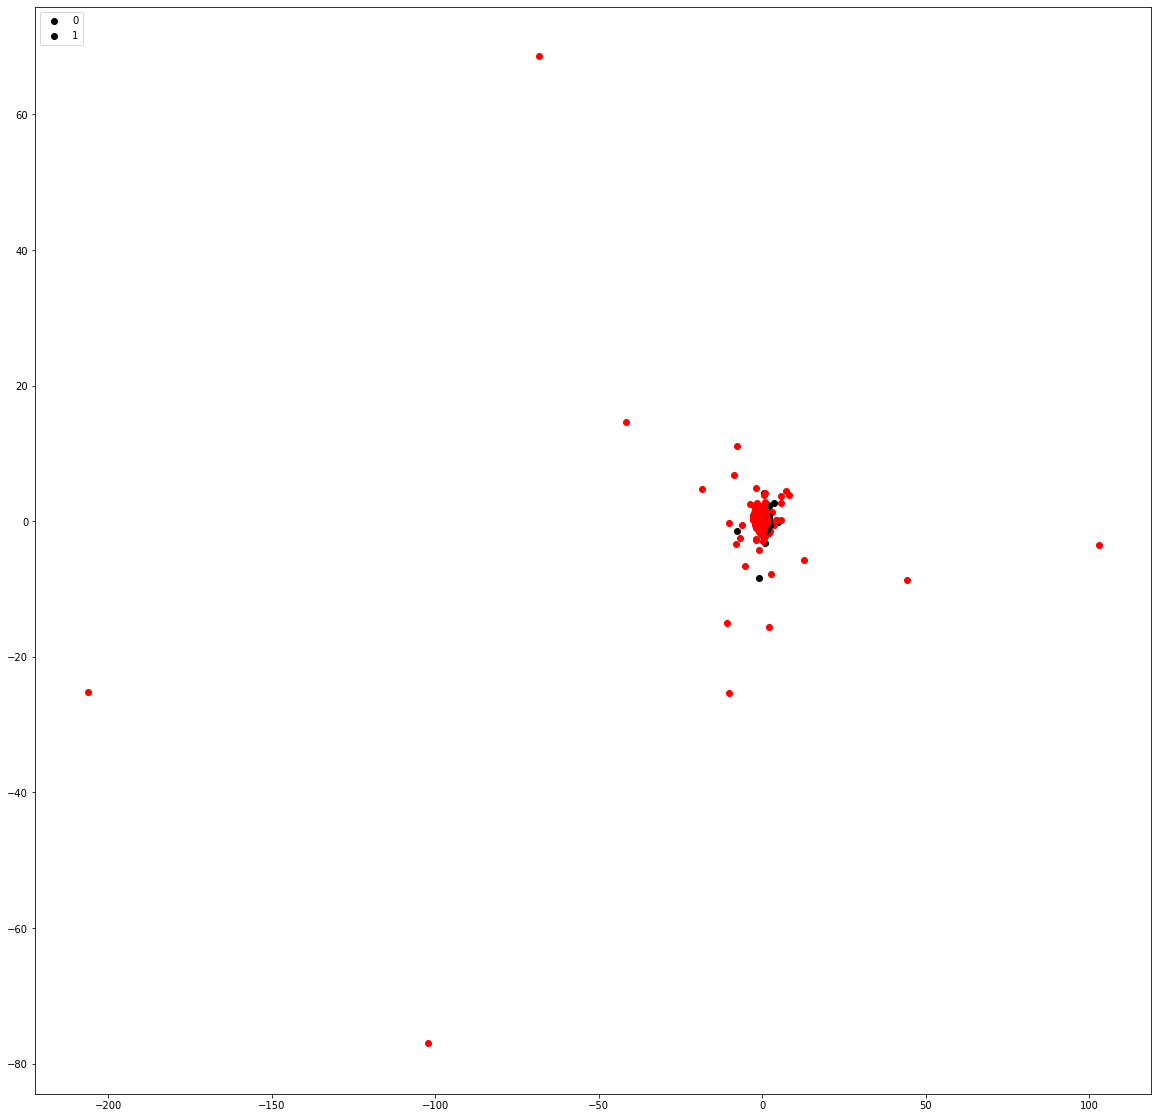

In [111]:
colors = {0: 'red', 1: 'black'}
tsne_plot_candidates(model, clus_df,colors,"agg_labels")

## Run all models eight times

Run each of the classifiers for the following 2 x 2 x 2 = 8 configurations:
1. (all docs vs. fasttext-selected)
1. (refined vs. unrefined)
1. (word vector vs. score vectors)

In [163]:
# Keep a list of best models and best F scores
results = {}

## Found error problem
The error in the cell below is symbols that cannot be detected by unicode
for ex... 700â€‰000 is one where the middle is replaces with \u and it is re-intepreted to '700\u2009000'
This can be found in the excel sheet by searching 'SV-N-NA' and then moving over 2 cells. 

Another example is Mp = 1050âˆ’1â€‰870â€‰000 g/mol

We need to figure out where file 'classifier_pipeline_candidates.csv' was created to potentially see how this came to be.

In the meantime, a temp try except fix can be created but MUST be labeled in order for it to eventually be removed.

<br>


The results from running the models when trying to reproduce the original experiment were as follows. The data model from polymers.TEST file with the fasttext supervised training. 
Then, the refined model was run through the classification process where KNN, SVC with gridsearch, and RF with gridsearch were used to predict the candidate's valdiity. The results were as follows when doing this method...
    

In [31]:
# process_full_document_flag   = True
# refined_candidates_only_flag = False
# use_word_vector_flag         = False

# predictions = run_all_models(X,y, results, process_full_document_flag, refined_candidates_only_flag, use_word_vector_flag)
# predictions

<h1>Experiment 1 part 2: unsupervised word vectors</h1>

In [164]:
X = np.array(get_X_from_df(df_exp1.unsupervised_coords))
X = pd.DataFrame(X)
y = df_exp1.is_groundtruth.astype('int')

print(X.shape,y.shape)

(923, 3) (923,)


In [390]:
# colors = {0: 'red', 1: 'black'}
# tsne_plot_candidates(unsupervised_model, [df_exp1.agg_labels],colors,"agg_labels")

In [165]:
process_full_document_flag   = False
refined_candidates_only_flag = False
use_word_vector_flag         = True


run_all_models(X, y, results, process_full_document_flag, refined_candidates_only_flag, use_word_vector_flag)

Running all classifiers, with unrefined candidates; word vectors; classified sentences
RUNNING THEM ALL NOW LENGTH OF X, y IS 923 923
[[0.34521905 0.35713851 0.07972284]
 [0.36023507 0.44907817 0.32709286]
 [0.30548009 0.22161408 0.36065477]
 ...
 [0.15847816 0.1248671  0.16890882]
 [0.14110993 0.20973969 0.38368177]
 [0.4769364  0.40396333 0.29259655]]
K Nearest Neighbor:
    Test points:     93
    True positives:  1
    False positive:  5
    True negatives:  71
    False negatives: 16
    Precision:       0.167
    Recall:          0.059
    F-1 score:       0.087
LEN X TRAIN 830
LEN X TESST 93
LEN Y PREDICTED 93
{'y_predicted': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0]), 'f1s': 0.08695652173913043}
Support Vector:

{'knn_pred': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]),
 'svc_pred': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]),
 'rf_pred': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])}

From the above, the unsupervised feature vectors that were taken from the entire set 
appear to have performed better in classification than the fasttext supervised
feature vectors taken from the 50 documents in every classifier. The KNN 
classifier stood out as the best performing one consistently in the above steps that try 
to reproduce the original research results. 

Below, we will create a gridsearch KNN, and then will check to see if probability cutoffs help improve the score

In [166]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

def knn_optimize(X_train,X_test,y_train,y_test):
    grid_params = {
        'n_neighbors': [3,5,7,9,11,13,15],
        'weights': ['uniform','distance'],
        'metric': ['euclidean','manhattan']
    }
    gs = GridSearchCV(
    neighbors.KNeighborsClassifier(),
    grid_params,
    verbose=1,
    cv=3,
    n_jobs=-1)
    
    gs_results = gs.fit(X_train,y_train)
    
    knn_cf = neighbors.KNeighborsClassifier(**gs_results.best_params_)
    knn_cf.fit(X_train,y_train)
    knn_pred_proba = knn_cf.predict_proba(X_test)
    knn_pred = knn_cf.predict(X_test)
    
    return gs_results,knn_pred_proba,knn_pred

def prob_optimize(y_pred_prob,y_test, cutoffs):
    
    f1_score_ls = []
    recall_ls = []
    precision_ls = []
    
    for cutoff in cutoffs:
        cutoff_pred = [1 if y[1] >= cutoff else 0 for y in y_pred_prob]
        f1_score_ls.append(f1_score(y_test,cutoff_pred))
        recall_ls.append(recall_score(y_test,cutoff_pred))
        precision_ls.append(precision_score(y_test,cutoff_pred))
        
    return {'f1_score':f1_score_ls,
           'recall': recall_ls,
           'precision': precision_ls}



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn_gs, knn_pred_proba, knn_pred = knn_optimize(X_train,X_test,y_train,y_test)

cutoffs = [0.3,0.4,0.5,0.6,0.7,0.8]
cutoff_scores = prob_optimize(knn_pred_proba,y_test,cutoffs)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  61 out of  84 | elapsed:    3.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    3.4s finished


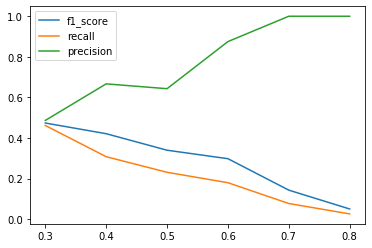

In [167]:
plt.plot(cutoffs,cutoff_scores['f1_score'],label="f1_score")
plt.plot(cutoffs,cutoff_scores['recall'],label="recall")
plt.plot(cutoffs,cutoff_scores['precision'],label="precision")
plt.legend(loc="upper left")

From the above, it can be seen that a probability cutoff of 0.3 yields the best results. We also see a drastic improvement in using a test size of .2 compared to .1 .

<h1>Next 11/3/2020 </h1>, take all candidates from here \evaluation\candidates\listformat cluster them, (100 docs)
id acronyms, and classify within that dataset. Try to look at cluster that contains acronym 'PS' .

Also, KNN AUC (for probability levels of it being a groundtruth)

Also, next 11/10/20, add the other acronyms from https://github.com/rtchoua/WordEmbeddingNER/blob/master/2_word_embedding_model1_gensim.ipynb and find their clusters as well

In [34]:

# def get_cluster_homogeneity(labels,words,ground_truths_hash):
#     cluster_frequency = Counter(labels)
#     ground_truths_in_clus = {k: 0 for k in labels}
    
#     for ix in range(0,len(words)):
#         candidate = words[ix]
#         cluster_label = labels[ix]
#         if candidate in ground_truths_hash:
#             ground_truths_in_clus[cluster_label] += 1
            
#     return ground_truths_in_clus, cluster_frequency

def get_homogeneity_proportion(ground_truths_in_clus, cluster_frequency):
    return {k: ground_truths_in_clus[k]/cluster_frequency[k] for k in list(cluster_frequency)}

In [35]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, OPTICS, KMeans

def run_dbscan(X):
    clustering = DBSCAN().fit(X)
    return clustering.labels_
    
def run_kmeans(X,params):
    clustering = KMeans(**params).fit(X)
    return clustering.labels_

def run_optics(X,args):
    optics = OPTICS(**args).fit(X)
    return optics.labels_

def run_agg_clustering(X,args):
    clustering = AgglomerativeClustering(**args).fit(X)
    return clustering.labels_



Lets ensure we focus only on refined candidaes, with value "acceptable_after_refinement"

In [168]:
fulldoc_df = df_exp1.copy()#create_df(fulldoc_candidates,model=unsupervised_model,ground_truths=ground_truths)
unsupervised_coords = get_similarity_scores_as_features(fulldoc_df.candidate, unsupervised_model,  ["polystyrene","poly(styrene)","PS"])
fulldoc_df.unsupervised_coords = unsupervised_coords

fulldoc_df.is_refined.value_counts()

acceptable_after_refinement    923
Name: is_refined, dtype: int64

In [169]:
fulldoc_df = fulldoc_df[fulldoc_df.is_refined=="acceptable_after_refinement"]
#fulldoc_df = fulldoc_df.reindex(range(len(fulldoc_df)))
fulldoc_df.index = pd.RangeIndex(start=0,stop=len(fulldoc_df),step=1)

fulldoc_df.is_refined.value_counts()

acceptable_after_refinement    923
Name: is_refined, dtype: int64

In [170]:
X = np.array(get_X_from_df(fulldoc_df.unsupervised_coords))
X = pd.DataFrame(X)

Before running clustering, let's define the logic needed
to see which cluster "PS" is in, and see if this cluster is predominantly acronyms.<br>
Additionally, we will create a function that writes to 3 files. The first file will contain the input parameters to the algorithm. The 2nd file will contain the statistics for homogeneity,
and the third file will contain all the polymers that were found in the same cluster as "PS". Also, draw Silhouette curve for the clusters. We will be focusing on Agglomerative going forward.<br><br>https://github.com/rtchoua/WordEmbeddingNER/blob/master/2_word_embedding_model1_gensim.ipynb
PMMA
PEO
https://docs.google.com/document/d/1bg1gcx_V1Ze2mYY3n1GQN2qb4neBKypYgazUreKfa68/edit
Snorkel


In [171]:
import json

def find_acronyms(df, labels, acronyms):
    """returns the clusters acronyms are in, as well as all the candidates that were labeled with this cluster"""
    candidates_in_clus = []
    acronym_clusters = []
    df["clus_labels"] = labels

    acronym_clus = []
    for acronym in acronyms:
        acronym_ix = df.candidate[df.candidate==acronym].index[0]
        cur_acronym_clus = labels[acronym_ix]
        acronym_clusters.append(cur_acronym_clus)
        candidates_in_clus += [candidate for candidate in df[df.clus_labels==cur_acronym_clus].candidate]
    
    return acronym_clusters, candidates_in_clus

def write_files(runs,algo,acronyms,df=fulldoc_df):
    acronyms_str = ''.join(acronyms)
    for ix in range(len(runs)):
        cur_run = runs[ix]
        
        with open('fulldocclustering/{}params{}{}.txt'.format(algo,str(ix),acronyms_str),'w') as f:
            f.write(json.dumps(cur_run["params"]))
            
#         with open('fulldocclustering/{}homogeneity{}{}.txt'.format(algo,str(ix),acronyms_str),'w') as f:
#             f.write("total per clus: \n\n")
#             total_per_clus = cur_run["total_per_clus"]
#             total_per_clus_str = {str(k): str(total_per_clus[k]) for k in list(total_per_clus)}
#             f.write(json.dumps(total_per_clus_str)+'\n')
            
#             homogeneity_per_clus = cur_run["clus_homogeneity_proportion"]
#             homogeneity_per_clus_str = {str(k): str(total_per_clus[k]) for k in list(homogeneity_per_clus)}
#             f.write("homogeneity proportion per clus: \n\n")
#             f.write(json.dumps(homogeneity_per_clus_str)+"\n\n")
#             f.write("silhouette score: {}".format(str(cur_run["silhouette"])))
            
        with open('fulldocclustering/{}ps_clus_cands{}{}.txt'.format(algo,str(ix),acronyms_str),'w',encoding='utf-8') as f:
            ps_clus, cands_in_ps_clus = find_acronyms(df, cur_run["labels"],acronyms)
            f.write("ps cluster label: {}\n\n".format(str(ps_clus)))
            for cand in cands_in_ps_clus:
                f.write(cand+'\n')

<h1>OPTICS clustering</h1>

In [172]:
#ground_truths_hash = 
opt_runs = []
opt_min_samples = [5,8,11,14]
opt_distances = ["minkowski","cosine"]
leaf_sizes = [20,25,30,35,40]

for min_sample_size in opt_min_samples:
    for metric in opt_distances:
        for leaf_size in leaf_sizes:
            params = {"min_samples":min_sample_size,
                     "metric": metric,
                     "leaf_size": leaf_size}
            labels = run_optics(X,params)
            
          #  opt_gt_total, opt_counter = get_cluster_homogeneity(labels,fulldoc_df.candidate,ground_truths_hash)
          #  proportion = get_homogeneity_proportion(opt_gt_total, opt_counter)
            opt_runs.append({"params":params,
                             "labels":labels})
                            # "total_per_clus":opt_counter
                             #"clus_homogeneity_proportion": proportion})

In [173]:
write_files(opt_runs,"optics",acronyms=["PS"])

<h1>Agglomerative Clustering </h1>

In [174]:
from sklearn.metrics import silhouette_score


agg_runs = []
n_clusters = [2,3,4,5]
agg_linkage = ["ward","complete","average","single"]

for cluster_size in n_clusters:
    for linkage in agg_linkage:
        params = {"n_clusters":cluster_size,
                     "linkage": linkage}
        labels = run_agg_clustering(X,params)
            
    #    agg_gt_total, agg_counter = get_cluster_homogeneity(labels,fulldoc_df.candidate,ground_truths_hash)
    #    proportion = get_homogeneity_proportion(agg_gt_total, agg_counter)
        agg_runs.append({"params":params,
                             "labels":labels,
                          #   "total_per_clus":agg_counter})
                         #    "clus_homogeneity_proportion": proportion,
                            "silhouette":silhouette_score(X,labels)})

In [175]:
write_files(agg_runs,"agg",["PS"])

In [176]:
write_files(agg_runs,"agg",["PS","PMMA","PEO"])

In [177]:
[x['silhouette'] for x in agg_runs]

[0.34605894144699756,
 0.5418500134742427,
 0.6309071955941088,
 0.6250459714062533,
 0.33796444852070423,
 0.34675503307185807,
 0.5975516709171821,
 0.5933496802508984,
 0.3363038290785124,
 0.3092768017939306,
 0.4793071084101629,
 0.5943174474192882,
 0.26258205022890135,
 0.30205514596208155,
 0.4146768783348345,
 0.5845318022106909]

<h1>KMeans</h1>

In [178]:
kmeans_runs = []
k_params = [2,4,6,8,10,12]

for k in k_params:
    params = {"n_clusters":k}
    labels = run_kmeans(X,params)
            
 #   kmeans_gt_total, kmeans_counter = get_cluster_homogeneity(labels,fulldoc_df.candidate,ground_truths_hash)
  #  proportion = get_homogeneity_proportion(kmeans_gt_total, kmeans_counter)
    kmeans_runs.append({"params":params,
                    "labels":labels})
                    #"total_per_clus":kmeans_counter,
                       #      "clus_homogeneity_proportion": proportion})

In [179]:
write_files(kmeans_runs,"kmeans",["PS"])

After exploring each of the clustering output files,
 it seems agglomerative clustering does the best job of finding 
    other acronyms inside the cluster with 'PS'. 
    Next, we will add more common acronyms of https://docs.google.com/document/d/1bg1gcx_V1Ze2mYY3n1GQN2qb4neBKypYgazUreKfa68/edit
    
Also, silhouette curves will be drawn for Agglomerative clustering

Finally, we will look at sub-clustering for clusters with PS, PMMA, and PEO

In [180]:
labels = agg_runs[5]["labels"]
acronyms = ["PS","PMMA","PEO"]
fulldoc_df["agg_3labels"] = labels
cluster_labels = []
for acronym in acronyms:
    acronym_ix = fulldoc_df.candidate[fulldoc_df.candidate==acronym].index[0]
    cluster_labels.append(labels[acronym_ix])

Create a subset dataframe and run through clustering on only the clusters
that contained one of our defined acronyms in the previous run.

In [190]:
subset_df = fulldoc_df[fulldoc_df["agg_3labels"].isin(cluster_labels)]
subset_df.index = pd.RangeIndex(start=0,stop=len(subset_df),step=1)
X = np.array(get_X_from_df(subset_df.unsupervised_coords))
X = pd.DataFrame(X)

from sklearn.metrics import silhouette_score

agg_runs = []
n_clusters = [2,3,4,5]
agg_linkage = ["ward","complete","average","single"]

for cluster_size in n_clusters:
    for linkage in agg_linkage:
        params = {"n_clusters":cluster_size,
                     "linkage": linkage}
        labels = run_agg_clustering(X,params)
            
#         agg_gt_total, agg_counter = get_cluster_homogeneity(labels,subset_df.candidate,ground_truths_hash)
#         proportion = get_homogeneity_proportion(agg_gt_total, agg_counter)
        agg_data = {"params":params,
                             "labels":labels,
#                              "total_per_clus":agg_counter,
#                              "clus_homogeneity_proportion": proportion,
                               "silhouette":silhouette_score(X,labels)}
        agg_runs.append(agg_data)
        
write_files(agg_runs,"agg_subcluster5PSPMMAPEO",["PS","PMMA","PEO"],df=subset_df)

C:\Users\danlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [181]:
fulldoc_df.is_groundtruth.value_counts()

False    756
True     167
Name: is_groundtruth, dtype: int64

Next steps
1. Calculate homogeneity of agglomerative with ONLY PS for the following...

{"n_clusters": 2, "linkage": "complete"}<br>
{"n_clusters": 3, "linkage": "complete"}

2. Create TSNE plot with candidates from the above clusters vs rest of population

3. Repeat aggl individually for PMMA and PEO
4. Remember proportional cluster_size to population size whenn considering this.
5. Apply to different candidate set
6. Maybe also show some graph of the homogeneity over cluster size for each linkage method


In [217]:
def identify_cluster(df,cluster_list):
    df["temp_cluster_col"] = 0
    for ix in df.index:
        candidate = df.loc[ix,"candidate"]
        df.loc[ix,"temp_cluster_col"] = 1 if candidate in cluster_list else 0 
    
    return df

In [220]:
def tsne_plot_candidates(df,colors, clus_labels_name, outfile = "./clustering_coords.png"):


    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=250, random_state=23)
    all_values = tsne_model.fit_transform(get_X_from_df(df_exp1.unsupervised_coords))
    
    x0 = []
    y0 = []

    for value in all_values:
        x0.append(value[0])
        y0.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
        
    print("Beginning plotting..")
    for i in range(len(x0)):
        plt.scatter(x0[i],y0[i], color=colors[df.loc[i,clus_labels_name]])

        
    plt.legend(colors.keys(), loc="upper left")
    plt.savefig(outfile, format="png")
    plt.show()
    plt.close()

In [198]:
# n_clusters: 2, linkage: complete results...

TOP_PERFORMERS_DIR = 'fulldocclustering'

def get_polymer_percentage(file_name):
    with open(file_name,'r',encoding='utf-8') as f:
        top_performers = []
        for candidate in f.readlines():
            if candidate != '\n' and 'cluster label' not in candidate:
                top_performers.append(candidate.strip('\n'))

        top_performers = top_performers[1:]

    total_polymers = 0
    for polymer in top_performers:
        is_groundtruth = fulldoc_df.loc[fulldoc_df["candidate"]==polymer,"is_groundtruth"]
        #if candidate appears 
        total_polymers = (total_polymers + 1) if is_groundtruth.item() else total_polymers

    return (total_polymers/len(top_performers)), top_performers

top_polymers_1ps = get_polymer_percentage(TOP_PERFORMERS_DIR+'/aggps_clus_cands1PS.txt')
print(top_polymers_1ps[0])

0.46153846153846156


C:\Users\danlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `item` has been deprecated and will be removed in a future version


Beginning plotting..


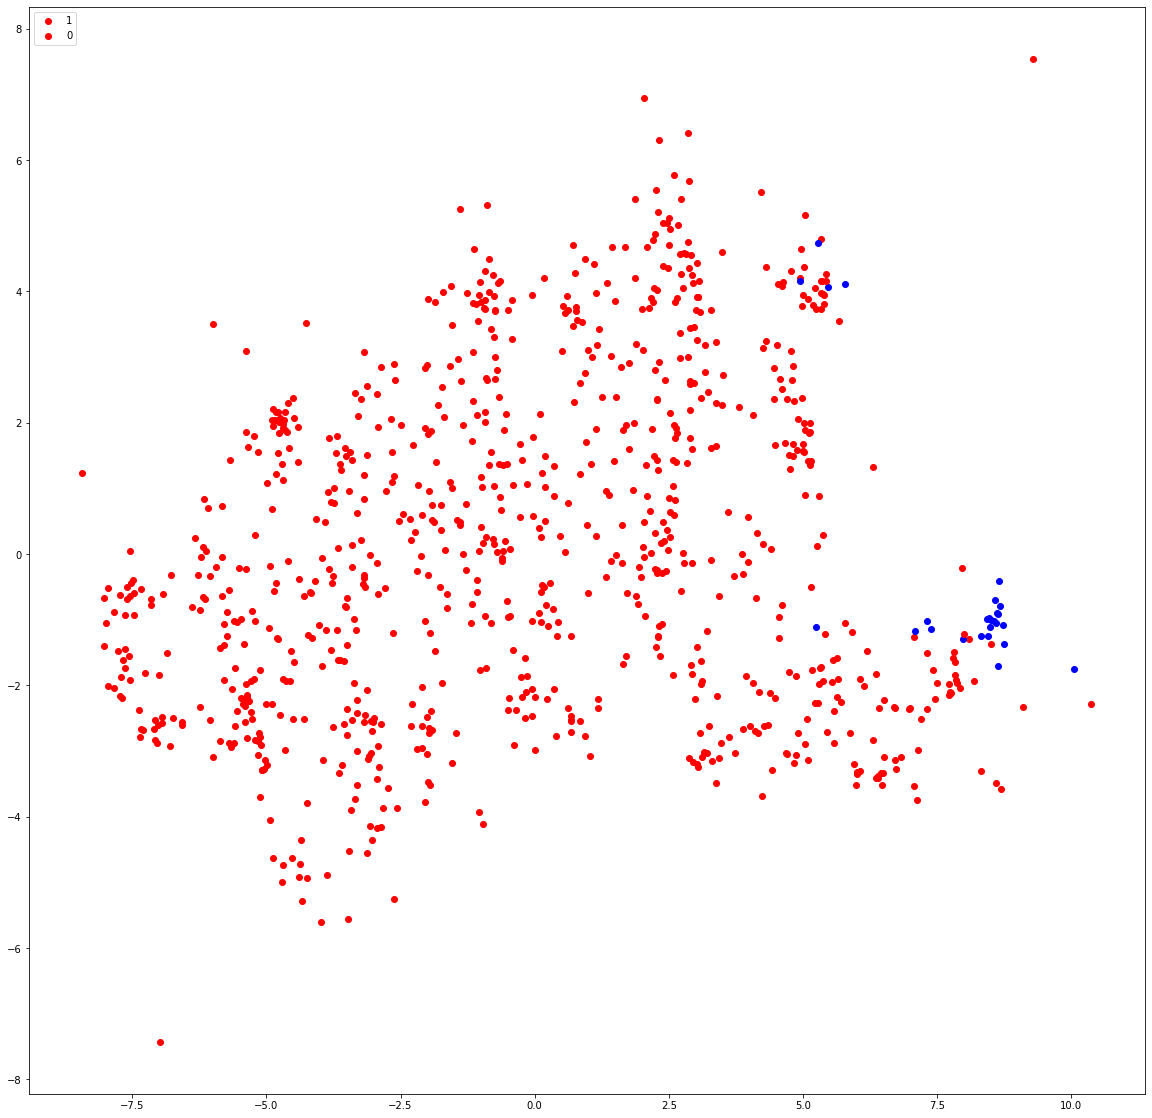

In [225]:
colors = {1:'blue', 0: 'red'}
labeled_df = identify_cluster(fulldoc_df,top_polymers_1ps[1])
tsne_plot_candidates(labeled_df,colors,"temp_cluster_col","agg_tsne_1ps.png")

In [183]:
pd.set_option('display.max_rows', 500)
fulldoc_df.loc[fulldoc_df["candidate"].isin(top_performers_2_linkage),["candidate","is_groundtruth"]]

,candidate,is_groundtruth
17,PMMA,True
71,poly(methyl acrylate),True
82,polybutadienes,False
83,polystyrenes,False
241,polybutadiene,True
253,poly(tert-butylstyrene),False
278,PS)/poly(vinyl methyl ether,False
284,PS/poly(methyl methacrylate),True
305,"poly(styrene-co-2,3,4,5,6-pentafluorostyrene)",True
362,PS–PMMA,False


Judging from the above, it appears that some of the candidates labeled as non-polymers are potentialyl polymers despite not appearing in the ground_truth file. Below, it can be seen that n_clusters of 2 and 3 for agglomerative resulted in the same homogeneity of the cluster containing 'PS'

In [188]:
get_polymer_percentage(TOP_PERFORMERS_DIR+'/aggps_clus_cands5PS.txt')

C:\Users\danlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `item` has been deprecated and will be removed in a future version


0.46153846153846156

Next, we will take a look below to see how kmeans did.

C:\Users\danlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `item` has been deprecated and will be removed in a future version


the proportion of true polymers was 0.34552845528455284
Beginning plotting..


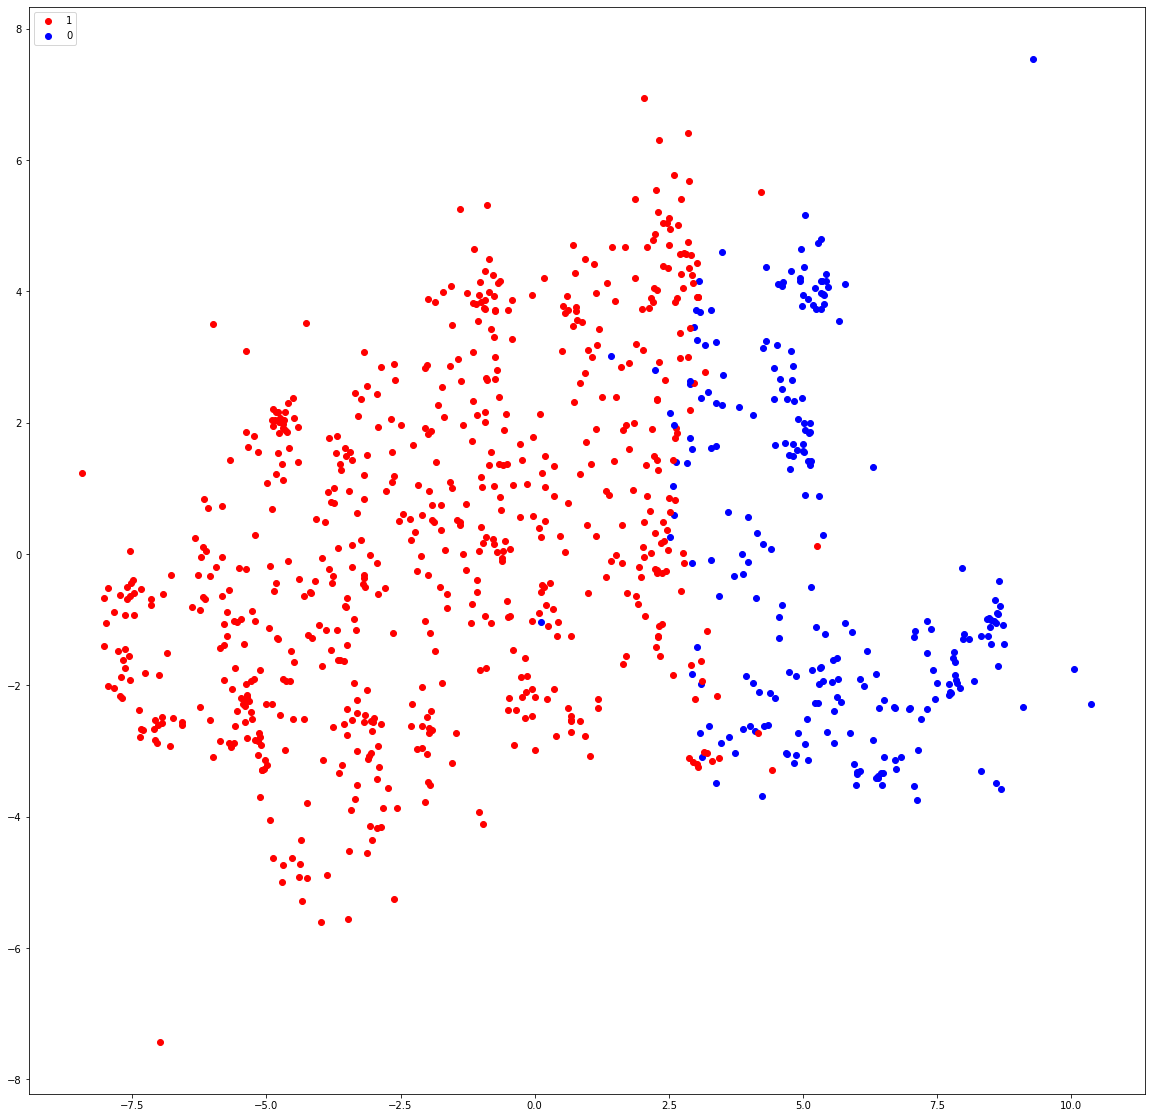

C:\Users\danlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `item` has been deprecated and will be removed in a future version


the proportion of true polymers was 0.2297872340425532
Beginning plotting..


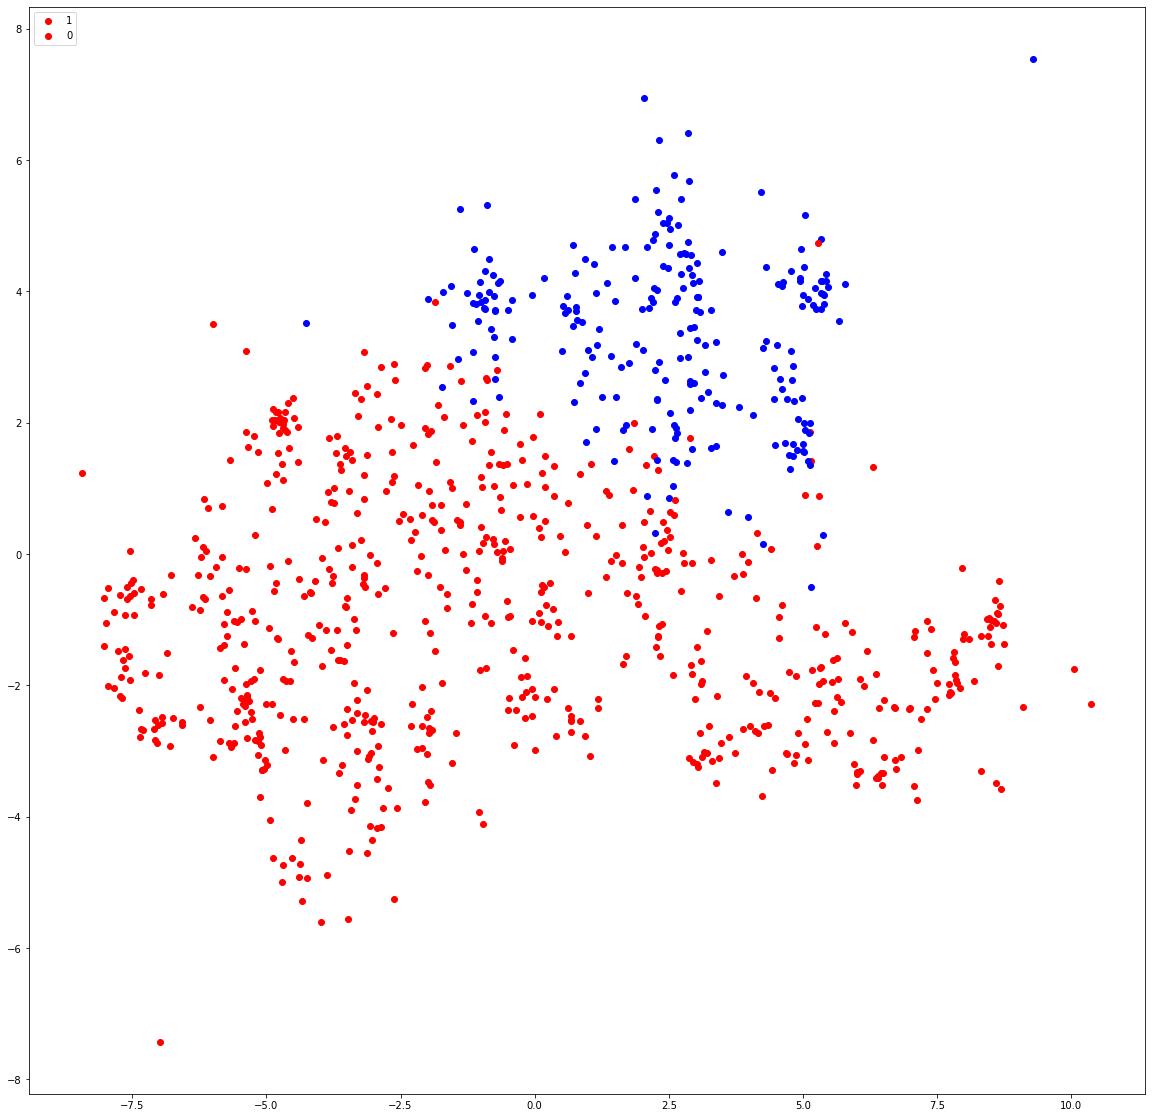

C:\Users\danlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `item` has been deprecated and will be removed in a future version


the proportion of true polymers was 0.5348837209302325
Beginning plotting..


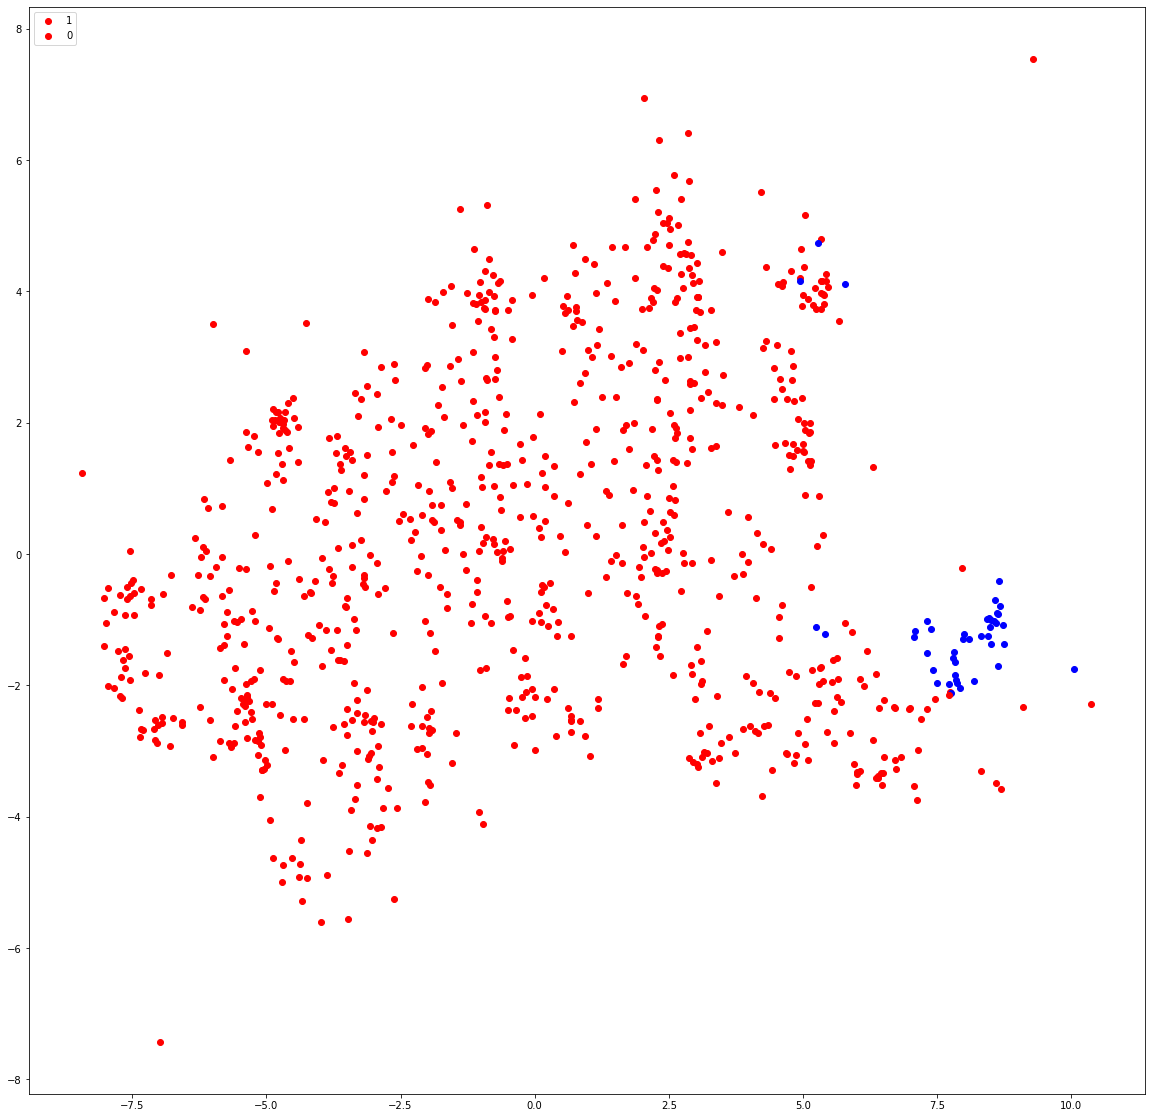

C:\Users\danlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `item` has been deprecated and will be removed in a future version


the proportion of true polymers was 0.24561403508771928
Beginning plotting..


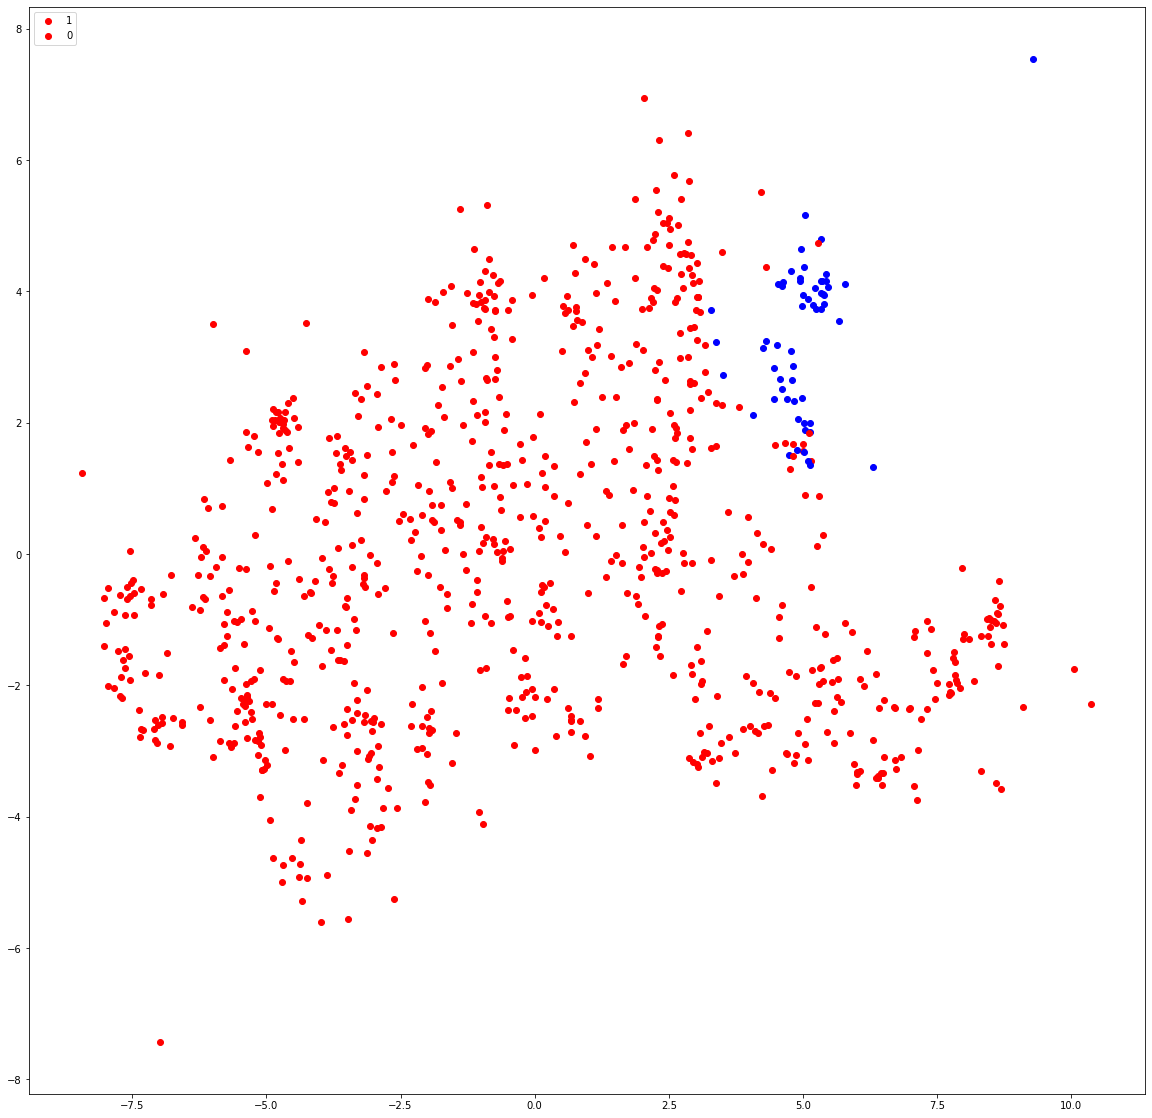

C:\Users\danlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `item` has been deprecated and will be removed in a future version


the proportion of true polymers was 0.3448275862068966
Beginning plotting..


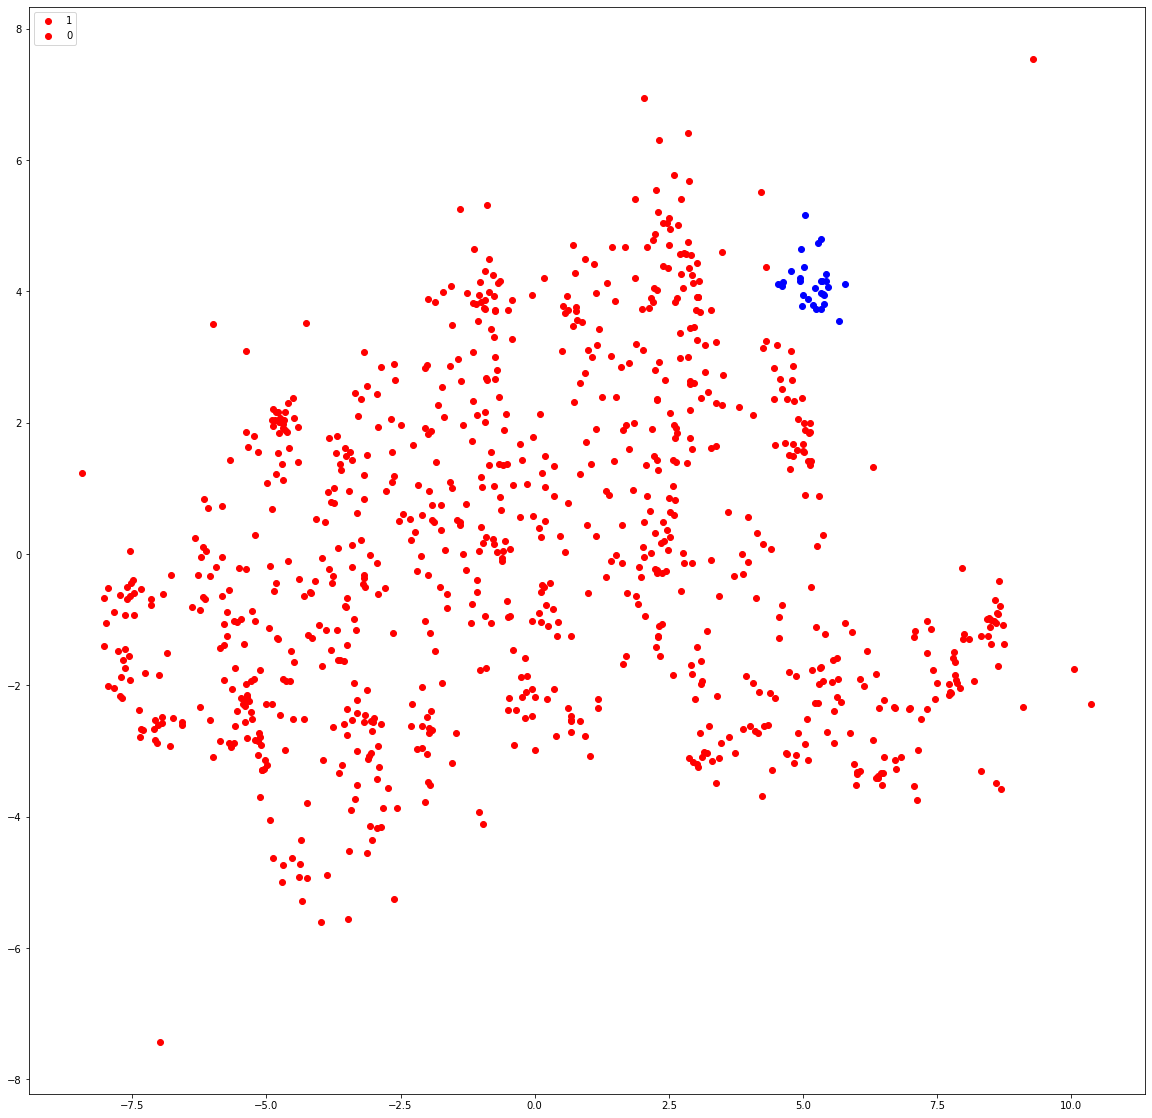

C:\Users\danlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `item` has been deprecated and will be removed in a future version


the proportion of true polymers was 0.3448275862068966
Beginning plotting..


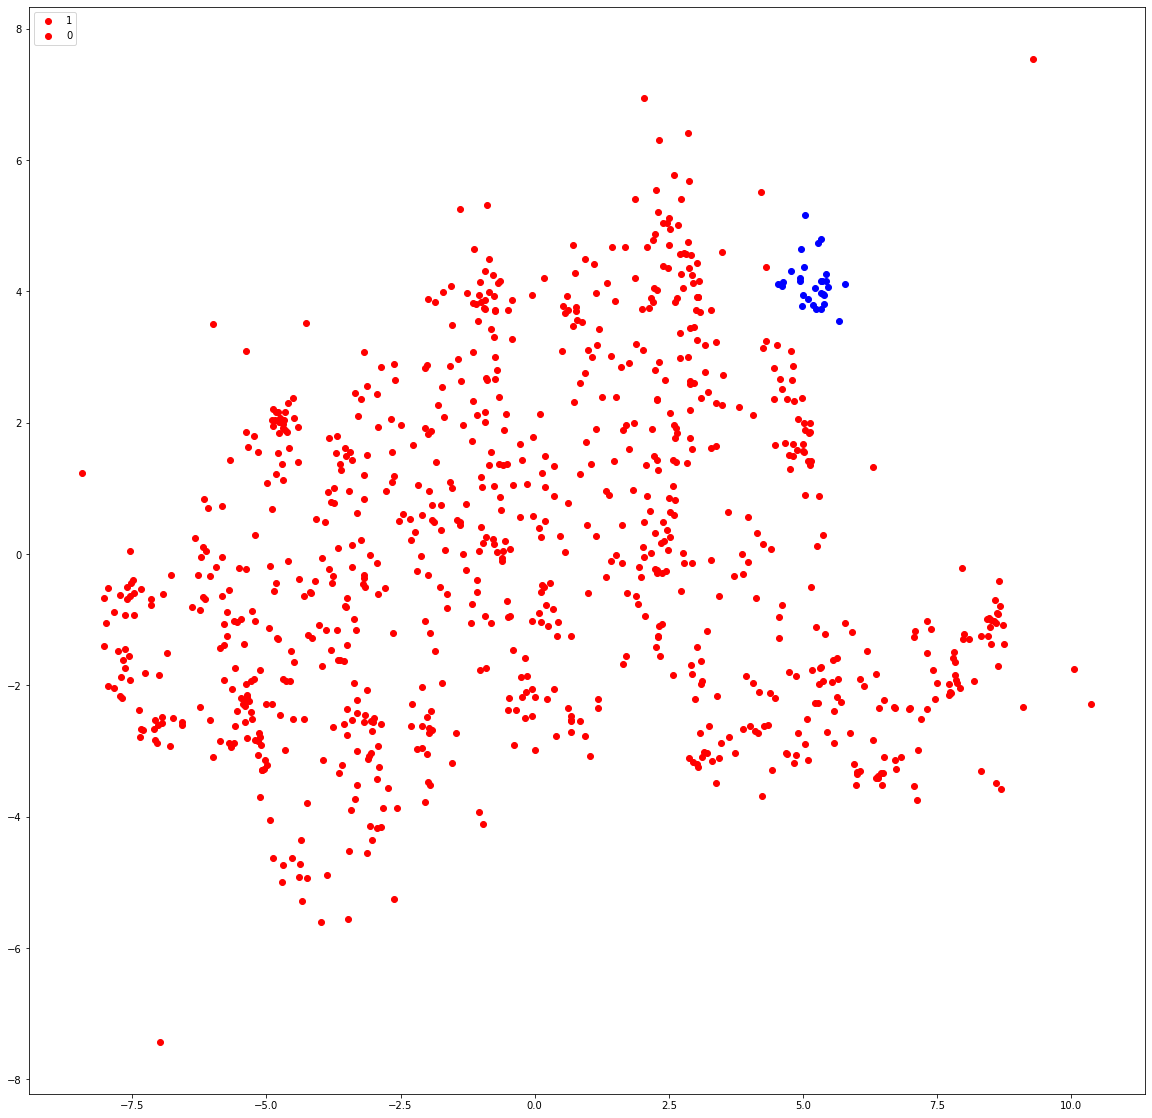

In [226]:
root_name = '/kmeansps_clus_cands'
for i in range(0,6):
    kmeans_candidates = get_polymer_percentage(TOP_PERFORMERS_DIR+root_name+str(i)+'PS.txt')
    print("the proportion of true polymers was {}".format(str(kmeans_candidates[0])))
    colors = {1:'blue', 0: 'red'}
    labeled_df = identify_cluster(fulldoc_df,kmeans_candidates[1])
    tsne_plot_candidates(labeled_df,colors,"temp_cluster_col","kmeans_tsne_{}.png".format(str(i)))

The above kmeans associated with kmeans run 2 had the highest cluster homogeneity. This has parameters {"n_clusters": 6}.
Interestingly, this plot is most similar to the agglomerative TSNE plot of the cluster that performed relatively well.